In [2]:
# import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pickle

In [43]:
# Suppress Warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None  

# Setting up the visual style for the plots
plt.style.use('ggplot')

In [44]:
# read the data file
df = pd.read_csv('data/energy_complete.csv')

In [45]:
# see the first few rows of the data
df.head()

,date,demand,RRP,demand_pos_RRP,RRP_positive,demand_neg_RRP,RRP_negative,frac_at_neg_RRP,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday
0,2015-01-01,99635.030,25.633696,97319.240,26.415953,2315.790,-7.240000,0.020833,13.3,26.9,23.6,0.0,N,Y
1,2015-01-02,129606.010,33.138988,121082.015,38.837661,8523.995,-47.809777,0.062500,15.4,38.8,26.8,0.0,N,N
2,2015-01-03,142300.540,34.564855,142300.540,34.564855,0.000,0.000000,0.000000,20.0,38.2,26.5,0.0,N,N
3,2015-01-04,104330.715,25.005560,104330.715,25.005560,0.000,0.000000,0.000000,16.3,21.4,25.2,4.2,N,N
4,2015-01-05,118132.200,26.724176,118132.200,26.724176,0.000,0.000000,0.000000,15.0,22.0,30.7,0.0,N,N


## Data Cleaning

In [46]:
# Handling missing values
# Remove rows with missing target values
df = df.dropna(subset=['RRP'])

# Fill missing numerical features with median values
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
for col in numeric_cols:
    df[col].fillna(df[col].median(), inplace=True)

# Fill missing categorical features with mode values
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Removing duplicates
df = df.drop_duplicates()

## Exploratory Data Analysis

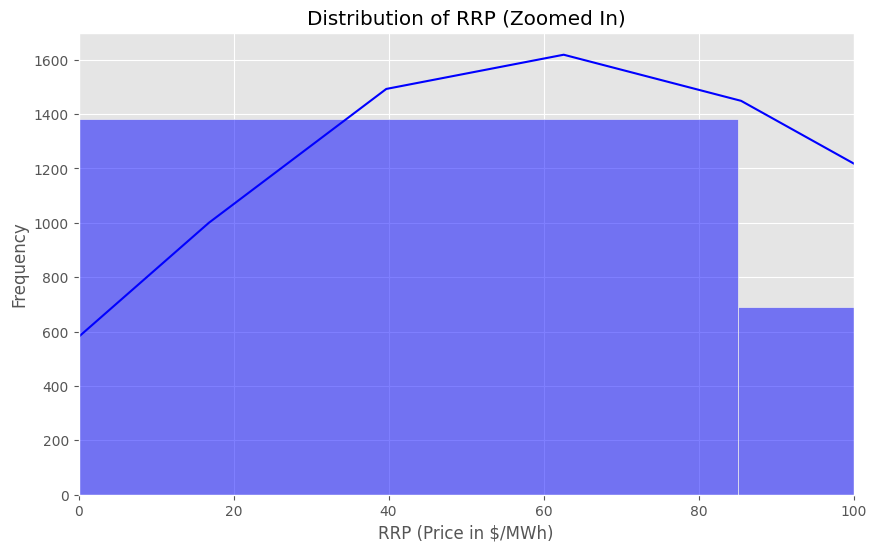

In [47]:
# 1. Plotting the distribution of RRP to understand its nature
plt.figure(figsize=(10, 6))
sns.histplot(df['RRP'], bins=50, kde=True, color='blue')
plt.xlim(0, 100)  # Zooming in to focus on RRP values between 0 and 100 $/MWh
plt.title('Distribution of RRP (Zoomed In)')
plt.xlabel('RRP (Price in $/MWh)')
plt.ylabel('Frequency')
plt.show()

#### The distribution plot of RRP shows that most electricity prices fall between 0 and 50 $/MWh, indicating that typical electricity prices are generally low, with a few instances of much higher values. The presence of outliers beyond 100 $/MWh suggests occasional spikes in pricing, which could be driven by unique market conditions.


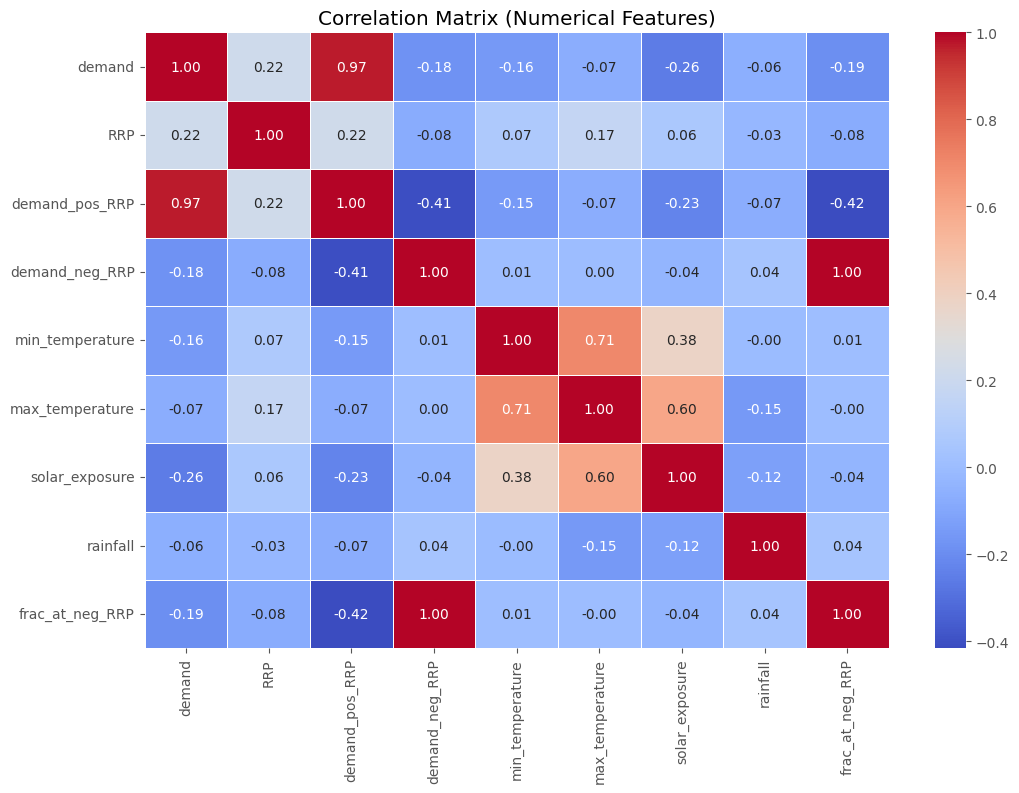

In [48]:
# 2. Correlation Matrix to understand relationships between features
# Including only relevant numerical columns for the correlation matrix
numeric_columns = ['demand', 'RRP', 'demand_pos_RRP', 'demand_neg_RRP', 'min_temperature', 
                   'max_temperature', 'solar_exposure', 'rainfall', 'frac_at_neg_RRP']

plt.figure(figsize=(12, 8))
correlation_matrix = df[numeric_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
plt.title('Correlation Matrix (Numerical Features)')
plt.show()

#### The correlation matrix reveals that features like 'demand' and 'demand_pos_RRP' have a significant positive correlation with RRP, suggesting that higher electricity demand is associated with higher prices. Some features also show high inter-correlations, such as 'min_temperature' and 'max_temperature', indicating potential multicollinearity that may need to be addressed in modeling.



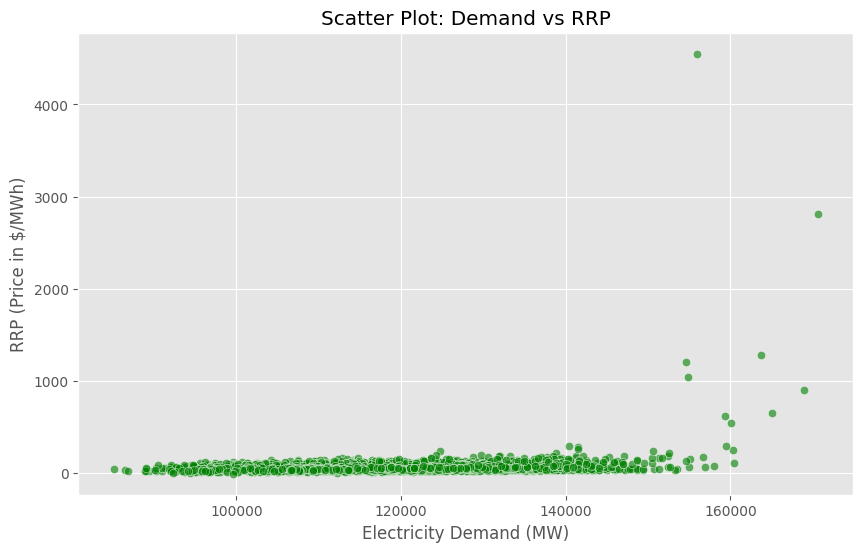

In [49]:
# 3. Relationship between Demand and RRP
plt.figure(figsize=(10, 6))
sns.scatterplot(x='demand', y='RRP', data=df, alpha=0.6, color='green')
plt.title('Scatter Plot: Demand vs RRP')
plt.xlabel('Electricity Demand (MW)')
plt.ylabel('RRP (Price in $/MWh)')
plt.show()

#### The scatter plot indicates a positive relationship between electricity demand and RRP. As demand increases, the RRP also tends to increase, though there is variability. This suggests that demand is an important factor affecting electricity prices, with higher demands generally resulting in higher prices.

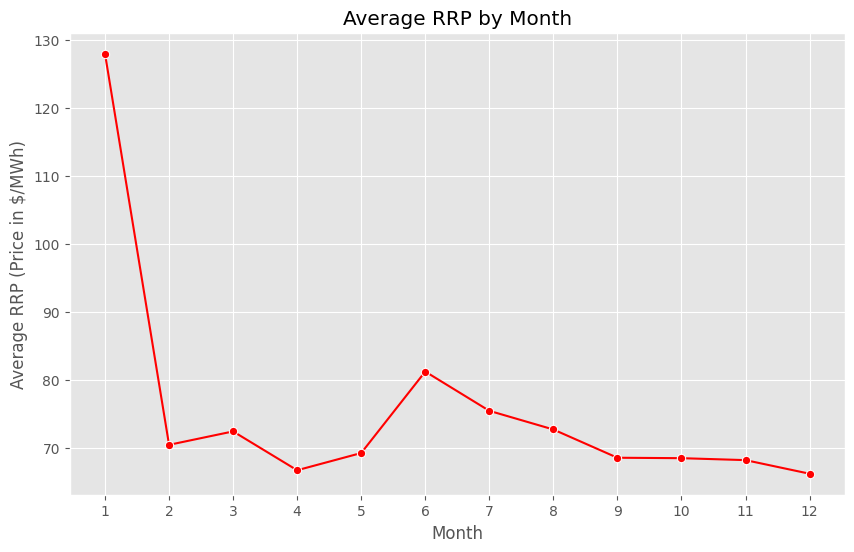

In [50]:
# 4. Average RRP by Month (Extracting Month from Date)
df['month'] = pd.to_datetime(df['date']).dt.month
monthly_rrp = df.groupby('month')['RRP'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.lineplot(x='month', y='RRP', data=monthly_rrp, marker='o', color='red')
plt.title('Average RRP by Month')
plt.xlabel('Month')
plt.ylabel('Average RRP (Price in $/MWh)')
plt.xticks(range(1, 13))
plt.show()

#### The line plot shows that average RRP tends to be higher in the summer months, particularly around January and February, which may correspond to increased cooling demand. There is a notable dip in the average RRP during the cooler months, indicating that electricity prices are influenced by seasonal demand patterns.

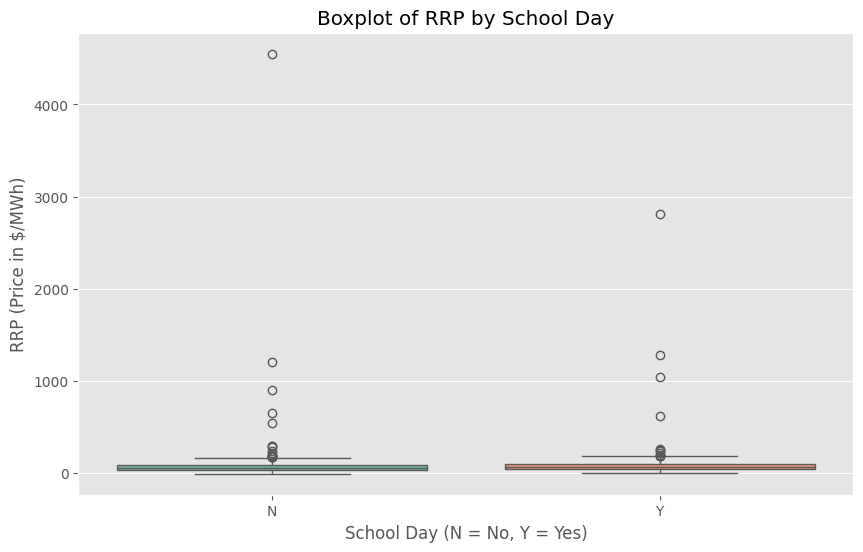

In [51]:
# 5. Boxplot of RRP by School Day to see its impact
plt.figure(figsize=(10, 6))
sns.boxplot(x='school_day', y='RRP', data=df, palette='Set2')
plt.title('Boxplot of RRP by School Day')
plt.xlabel('School Day (N = No, Y = Yes)')
plt.ylabel('RRP (Price in $/MWh)')
plt.show()

#### The boxplot shows that RRP tends to be slightly lower on school days compared to non-school days, though the difference is not drastic. This suggests that school day status might have some influence on electricity pricing, possibly due to changes in consumption patterns during school sessions.

## Machine Learning Model to Predict RRP


In [52]:
# Feature Selection and Preprocessing
features = ['demand', 'demand_pos_RRP', 'demand_neg_RRP', 'min_temperature', 'max_temperature', 'solar_exposure', 'rainfall', 'frac_at_neg_RRP', 'month', 'school_day']
X = df[features]
y = df['RRP']

# Handling categorical variables and missing values
X['school_day'] = X['school_day'].map({'Y': 1, 'N': 0})

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Data preprocessing pipeline
numeric_features = ['demand', 'demand_pos_RRP', 'demand_neg_RRP', 'min_temperature', 'max_temperature', 'solar_exposure', 'rainfall', 'frac_at_neg_RRP', 'month']
categorical_features = ['school_day']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', 'passthrough', categorical_features)
    ]
)

In [53]:
# Define models to train
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Support Vector Regressor': SVR()
}

# Cross-validation and hyperparameter tuning
best_model = None
best_score = -np.inf

for model_name, model in models.items():
    # Create pipeline with preprocessing and model
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('model', model)])
    
    # Performing cross-validation
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2')
    print(f"{model_name} Cross-Validation R^2 Scores: {cv_scores}")
    print(f"{model_name} Mean R^2 Score: {cv_scores.mean()}\n")
    
    # Hyperparameter tuning using GridSearchCV (example for RandomForest and SVR)
    if model_name == 'Random Forest':
        param_grid = {'model__n_estimators': [50, 100, 150], 'model__max_depth': [None, 10, 20]}
        grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2')
        grid_search.fit(X_train, y_train)
        model = grid_search.best_estimator_
        print(f"Best Parameters for Random Forest: {grid_search.best_params_}")
    elif model_name == 'Support Vector Regressor':
        param_grid = {'model__C': [0.1, 1, 10], 'model__kernel': ['rbf', 'linear']}
        grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2')
        grid_search.fit(X_train, y_train)
        model = grid_search.best_estimator_
        print(f"Best Parameters for SVR: {grid_search.best_params_}")
    else:
        pipeline.fit(X_train, y_train)

     # Train the model with the best parameters
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    score = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"{model_name} Test R^2 Score: {score}")
    print(f"{model_name} Test RMSE: {rmse}\n")
    
    # Track the best model
    if score > best_score:
        best_score = score
        best_model = pipeline

print(f"The best model is: {best_model.named_steps['model']} with R^2 Score: {best_score}")

Linear Regression Cross-Validation R^2 Scores: [-0.30896651  0.2159569   0.1034372  -1.47124006  0.06825734]
Linear Regression Mean R^2 Score: -0.27851102468228345

Linear Regression Test R^2 Score: -0.4490930209363315
Linear Regression Test RMSE: 48.79271370962053

Random Forest Cross-Validation R^2 Scores: [-3.17450971 -0.99808659  0.20564727 -0.47983629  0.22601101]
Random Forest Mean R^2 Score: -0.8441548627778804

Best Parameters for Random Forest: {'model__max_depth': None, 'model__n_estimators': 50}
Random Forest Test R^2 Score: -1.997366563588201
Random Forest Test RMSE: 70.1740868037674

Support Vector Regressor Cross-Validation R^2 Scores: [ 0.03115014 -0.00030954 -0.00121265  0.10410893 -0.00160452]
Support Vector Regressor Mean R^2 Score: 0.02642647143310082

Best Parameters for SVR: {'model__C': 10, 'model__kernel': 'rbf'}
Support Vector Regressor Test R^2 Score: 0.07819781714636753
Support Vector Regressor Test RMSE: 38.91577705383398

The best model is: SVR() with R^2 Sc

In [54]:
# Final Model Evaluation
y_final_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_final_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_final_pred)

print(f"Final Model Mean Squared Error: {mse}")
print(f"Final Model RMSE: {rmse}")
print(f"Final Model R^2 Score: {r2}")

Final Model Mean Squared Error: 1514.4377037037111
Final Model RMSE: 38.91577705383398
Final Model R^2 Score: 0.07819781714636753


In [55]:
# Save the best_model pipeline to a .bin file using pickle
with open('best_model.bin', 'wb') as model_file:
    pickle.dump(best_model, model_file)
    print("\nBest Model has been saved to 'best_model.bin'")


Best Model has been saved to 'best_model.bin'
